# Assignment 2: Spam Classification with SVM

### By Ali Shannon (aa3dc@virginia.edu)

---

### CS 4501 Machine Learning - Department of Computer Science - University of Virginia

![Spam email](https://www.saleshandy.com/blog/wp-content/uploads/2017/01/wsi-imageoptim-11-Reasons-Why-Your-Email-Ends-Up-In-Spam.png)

The purpose of this project is to classify emails as spam based on some word and character frequencies with some extra details to find the best SVM classifier for this dataset.

Files for this project are made available in the [UCI Machine Learning Repository](http://www.ics.uci.edu/~mlearn/MLRepository.html).


## 1. PRE-PROCESSING THE DATA (20 pts)

**Data Acquiring:** In this section all the data files must be extracted to the same folder where the Jupyter notebook file is.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# remove future warnings
import warnings
warnings.filterwarnings("ignore")

# preferred plotting style
plt.style.use('seaborn-pastel')

# use the columns file for headers
cols = pd.read_csv('spambase.columns', header = None)

# append the classification column as 'spam'
cols = cols.append(['spam'])

d = pd.read_csv('spambase.data', header = None)

df = pd.DataFrame(data = d.values, columns = cols[0].values)

# show a random set of 5 examples
df.sample(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
3683,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.000,0.000,0.0,0.0,0.0,1.000,1.0,3.0,0.0
4412,0.71,0.0,0.71,0.0,0.0,0.0,0.0,0.00,0.0,0.71,...,0.0,0.000,0.000,0.0,0.0,0.0,1.032,2.0,32.0,0.0
2584,0.00,0.0,0.91,0.0,0.0,0.0,0.0,0.45,0.0,0.00,...,0.0,0.000,0.000,0.0,0.0,0.0,1.320,7.0,103.0,0.0
69,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.201,0.000,0.0,0.1,0.0,4.548,59.0,141.0,1.0
1844,0.00,0.0,0.54,0.0,0.0,0.0,0.0,0.00,0.0,0.00,...,0.0,0.188,0.047,0.0,0.0,0.0,1.745,12.0,89.0,0.0


**Data Discovery:** here is the general overview of the correlation heatmap, might be a bit difficult to show the values since there are many features

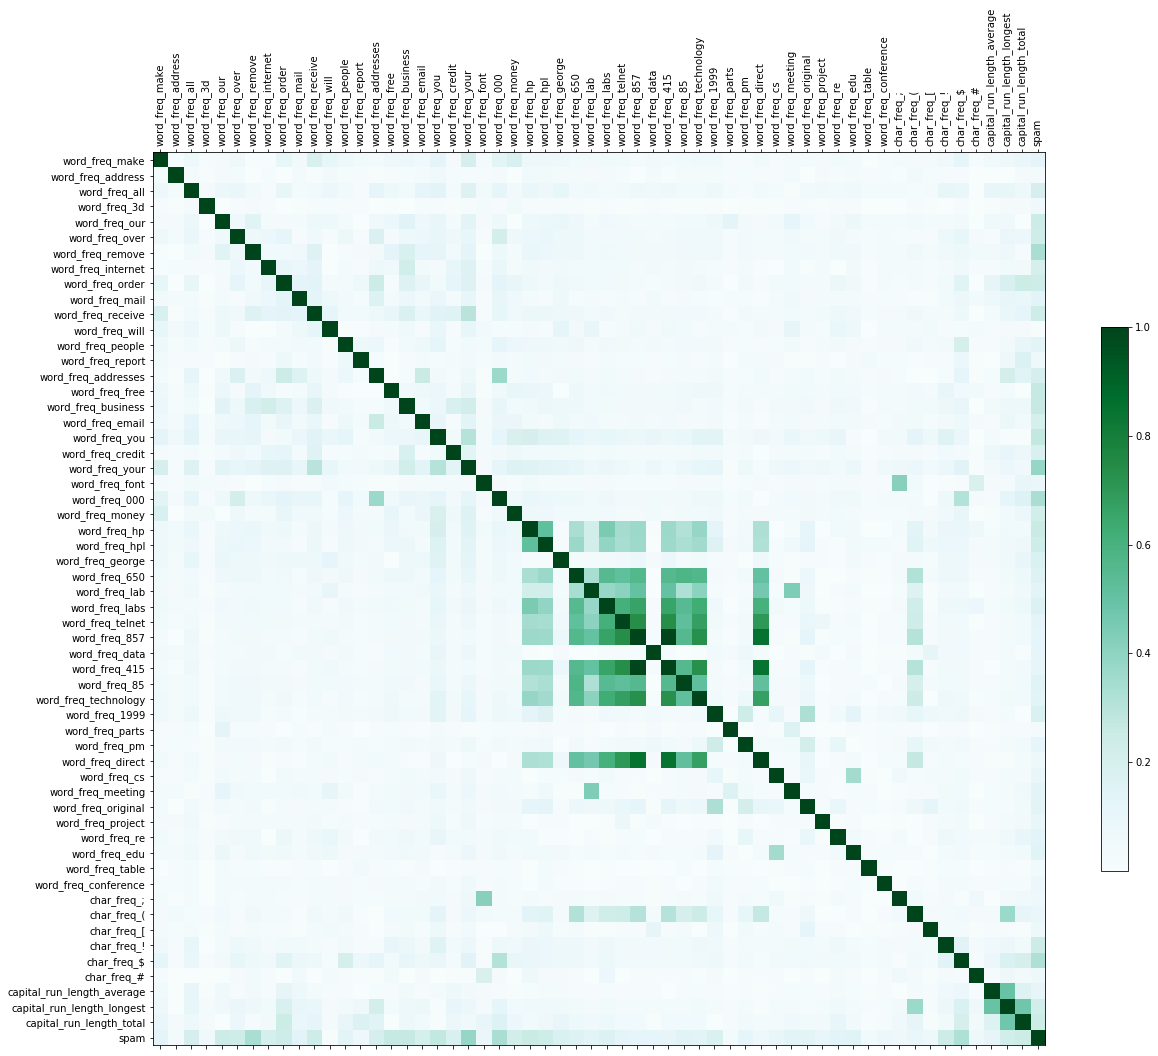

In [2]:
corr = df.corr().abs()
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(corr, cmap = 'BuGn')
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation='vertical');
plt.yticks(np.arange(len(corr.columns)), corr.columns);
fig.colorbar(cax, shrink = 0.5)

# this would show the values if there were fewer features, image must be scaled up too
#for (i, j), z in np.ndenumerate(corr):
#    ax.text(j, i, '{:.2f}'.format(z), ha='center', va='center')

plt.show()

The last row/column indicates correlation of each feature with the spam classifier, let's take a closer look at these values to see which features are most highly correlated.

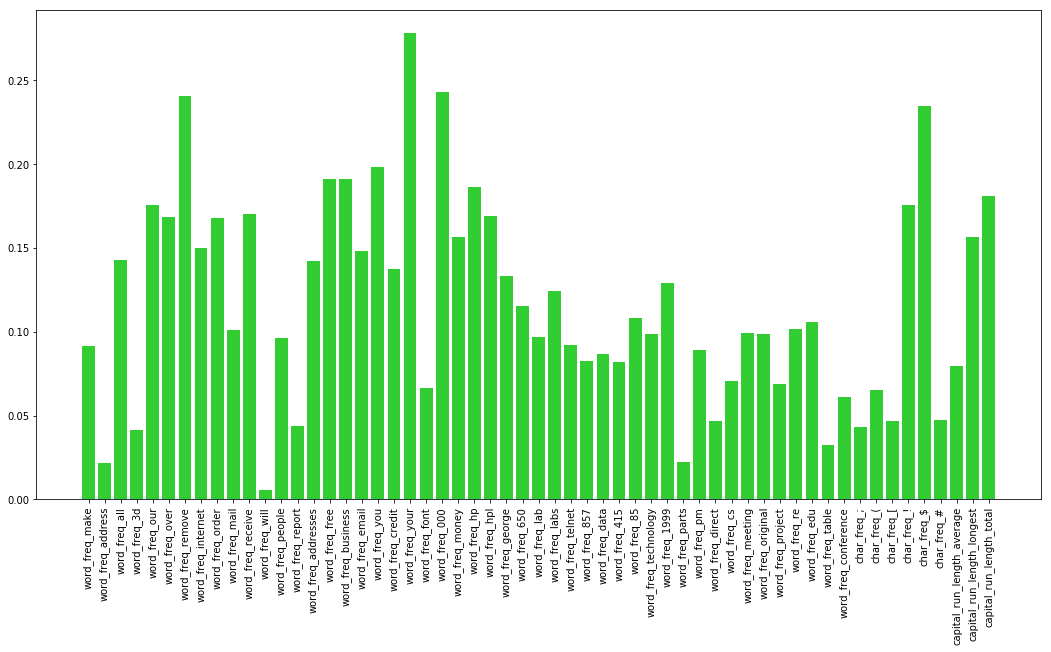

The top five correlated features are:  ['word_freq_your' 'word_freq_000' 'word_freq_remove' 'char_freq_$'
 'word_freq_you']


In [3]:
a = corr.values[-1]
a = np.delete(a, -1)
f = np.delete(cols[0].values, -1)

a /= np.linalg.norm(a)

plt.figure(figsize=(18,9))
plt.bar(f, a, color = 'limegreen');
plt.xticks(range(len(f)), f, rotation='vertical');
plt.show()


b = np.argsort(a)[::-1][:5]

print('The top five correlated features are: ', np.array([f[x] for x in b]))

This makes sense because spam mail usually uses dollar signs and some dollar amount with some trailing zeros.

---

**Data Cleaning:** even though the documentation of the data said there are no missing values, I'll check if we have any missing values.

In [4]:
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/df.shape[0]
print(f'{missing_values *100} %')

Series([], dtype: float64) %


We do not have any missing values. Let's see how the dataset is balanced.

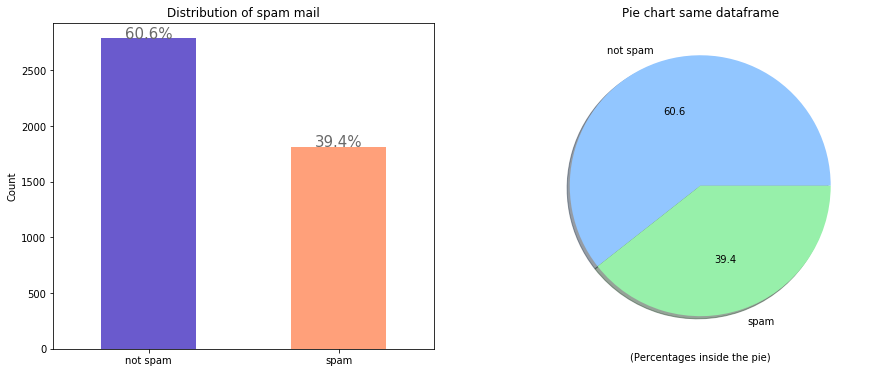

In [5]:
plt.figure(figsize=(15,6))

plt.subplot(121)
ax = pd.value_counts(df['spam']).plot.bar(color= ['slateblue', 'lightsalmon']);
ax.set_xlabel('');
plt.xticks(np.arange(2), ['not spam', 'spam'], rotation='horizontal')
ax.set_ylabel('Count');
ax.set_title('Distribution of spam mail')

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.125, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

plt.subplot(122)
pd.value_counts(df['spam']).plot.pie(autopct='%.1f', labels = ['not spam', 'spam'], shadow = True);
plt.xlabel('(Percentages inside the pie)');
plt.ylabel('');
plt.title('Pie chart same dataframe')
plt.show()

The balancing is not too bad but we need the model to understand the relationships and not become biased. Here I will perform simple undersampling to ensure a 50:50 balanced dataset for binary classification.

After performing sampling, these are the new distributions:



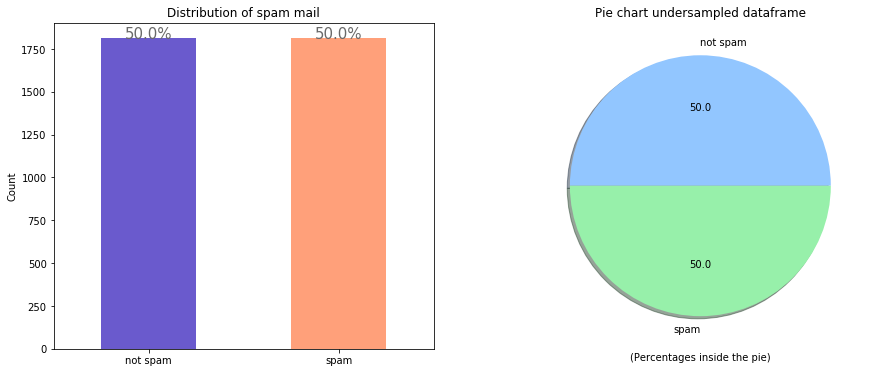

In [6]:
# perform undersampling by cutting out excess non-spam entries

spam = len(df[df['spam'] == 1])

non_spam_indices = df[df['spam'] == 0].index
spam_indices = df[df['spam'] == 1].index

# pick random index values to ensure disorder
random_indices = np.random.choice(non_spam_indices, spam, replace=False)

under_sample_indices = np.concatenate([spam_indices, random_indices])

# this is the undersampled dataframe
under_sample = df.loc[under_sample_indices]

# sampling is done at this point, the rest is just for plotting

print('After performing sampling, these are the new distributions:\n')

plt.figure(figsize=(15,6))

plt.subplot(121)
ax = pd.value_counts(under_sample['spam']).plot.bar(color= ['slateblue', 'lightsalmon']);
ax.set_xlabel('');
plt.xticks(np.arange(2), ['not spam', 'spam'], rotation='horizontal')
ax.set_ylabel('Count');
ax.set_title('Distribution of spam mail')

totals = []

for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.125, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')

plt.subplot(122)
pd.value_counts(under_sample['spam']).plot.pie(autopct='%.1f', labels = ['not spam', 'spam'], shadow = True);
plt.xlabel('(Percentages inside the pie)');
plt.ylabel('');
plt.title('Pie chart undersampled dataframe')
plt.show()

Now we have successfully made a balanced dataset.

---

**Feature Scaling:** since all models will use the scaled features, feature scaling will be performed before splitting.


**Data Splitting:** split the dataset into 80% training and 20% testing. 

In [7]:
X = under_sample.drop(['spam'], axis = 1).values
y = under_sample['spam'].astype(int).values

from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## 2. TRAINING LINEAR SVM FOR SPAM CLASSIFICATION (15 pts)

This first model will just show the basic case where **C = 1** and the **loss = 'hinge'**

Accuracy 92.70%
Precision score 93.58%
Recall score 92.35%
F1 score 92.96%


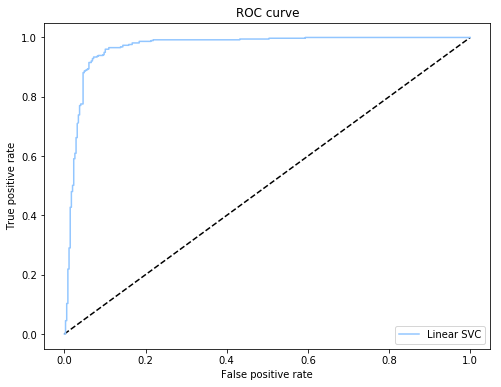

In [8]:
from sklearn.svm import LinearSVC
from sklearn import metrics


# Training your svm here

linear_svm_clf = LinearSVC(C = 1 , loss= "hinge", random_state=42)

linear_svm_clf.fit(X_train, y_train)

y_score = linear_svm_clf.decision_function(X_test)
y_pred = linear_svm_clf.predict(X_test)

# Testing your svm here

print('Accuracy {:2.2%}'.format(metrics.accuracy_score(y_pred = y_pred, y_true = y_test)))
print('Precision score {:2.2%}'.format(metrics.precision_score(y_pred = y_pred, y_true = y_test)))
print('Recall score {:2.2%}'.format(metrics.recall_score(y_pred = y_pred, y_true = y_test)))
print('F1 score {:2.2%}'.format(metrics.f1_score(y_true = y_test, y_pred = y_pred)))

fpr, tpr, _ = metrics.roc_curve(y_test, y_score)

plt.figure(1, figsize=(8,6))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Linear SVC');
plt.legend(loc='lower right')
plt.show()

---

## 3. TUNING REGULARIZATION HYPER-PARAMETER C (15 pts)

Here I am using `GridSearchCV` to search for the best value of the hyperparameter `C` using precision as the scoring method. Precision will help me capture all spam that is actually spam and not include lots of non spam mail. This might let some spam mail to go through but that is bound to happen when we maximize recall.

Results using the best model with best parameter: {'C': 2}
Accuracy 92.84%
Precision score 93.37%
Recall score 92.88%
F1 score 93.12%


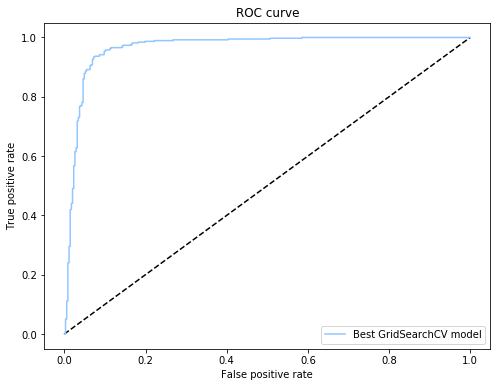

This is how this GridSearchCV works:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.056153,0.014144,0.004091,0.003947,0.5,{'C': 0.5},0.926056,0.914384,0.932143,0.937956,...,0.931031,0.010356,4,0.947038,0.943850,0.946237,0.943162,0.944395,0.944936,0.001465
1,0.057547,0.010258,0.001197,0.000747,1,{'C': 1},0.925532,0.917526,0.928571,0.941606,...,0.932192,0.010984,2,0.947085,0.942171,0.945584,0.945730,0.941441,0.944402,0.002196
2,0.102830,0.019840,0.006584,0.009537,2,{'C': 2},0.926056,0.923875,0.929078,0.941818,...,0.932881,0.008210,1,0.944643,0.942325,0.943900,0.940760,0.939856,0.942297,0.001811
3,0.154594,0.024846,0.000997,0.000002,10,{'C': 10},0.922261,0.927835,0.921986,0.941176,...,0.931408,0.009323,3,0.947180,0.945633,0.942478,0.948122,0.937667,0.944216,0.003794
4,0.300260,0.039808,0.001795,0.001163,100,{'C': 100},0.888136,0.875399,0.891525,0.921348,...,0.899212,0.018212,5,0.896290,0.899749,0.907627,0.911871,0.919298,0.906967,0.008278
5,0.304916,0.031112,0.001396,0.000488,200,{'C': 200},0.838006,0.907216,0.878893,0.849840,...,0.873798,0.026284,7,0.848509,0.910044,0.895288,0.849162,0.888592,0.878319,0.025055
6,0.342227,0.052567,0.009265,0.015574,500,{'C': 500},0.885906,0.886986,0.898305,0.903226,...,0.897047,0.009545,6,0.885593,0.902972,0.909633,0.893450,0.904135,0.899157,0.008552




I will use the best parameter {'C': 2} because I want to maximize the precision for this model.


In [9]:
from sklearn.model_selection import GridSearchCV

params = {'C': [0.5, 1, 2, 10, 100, 200, 500]}

linear_svm_cv = GridSearchCV(LinearSVC(loss= "hinge"), params, scoring = 'precision', cv = 5)
     
linear_svm_cv.fit(X_train, y_train)

results = pd.DataFrame(linear_svm_cv.cv_results_)

y_score_cv = linear_svm_cv.decision_function(X_test)
y_pred_cv = linear_svm_cv.predict(X_test)

cv_fpr, cv_tpr, _ = metrics.roc_curve(y_test, y_score_cv)

lin_acc = metrics.accuracy_score(y_pred = y_pred_cv, y_true = y_test)
lin_prec = metrics.precision_score(y_pred = y_pred_cv, y_true = y_test)
lin_recall = metrics.recall_score(y_pred = y_pred_cv, y_true = y_test)
lin_f1 = metrics.f1_score(y_true = y_test, y_pred = y_pred_cv)
lin_auc = metrics.roc_auc_score(y_true = y_test, y_score = y_pred_cv)


print('Results using the best model with best parameter:', linear_svm_cv.best_params_)
print('Accuracy {:2.2%}'.format(lin_acc))
print('Precision score {:2.2%}'.format(lin_prec))
print('Recall score {:2.2%}'.format(lin_recall))
print('F1 score {:2.2%}'.format(lin_f1))

plt.figure(2, figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(cv_fpr, cv_tpr, label = 'Best GridSearchCV model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

print('This is how this GridSearchCV works:')

from IPython.display import display
display(results)

print('\n\nI will use the best parameter {} because I want to maximize the precision for this model.'.format(linear_svm_cv.best_params_))

---

## 4. SELECTING THE FEATURES WITH LINEAR SVM (20 pts)



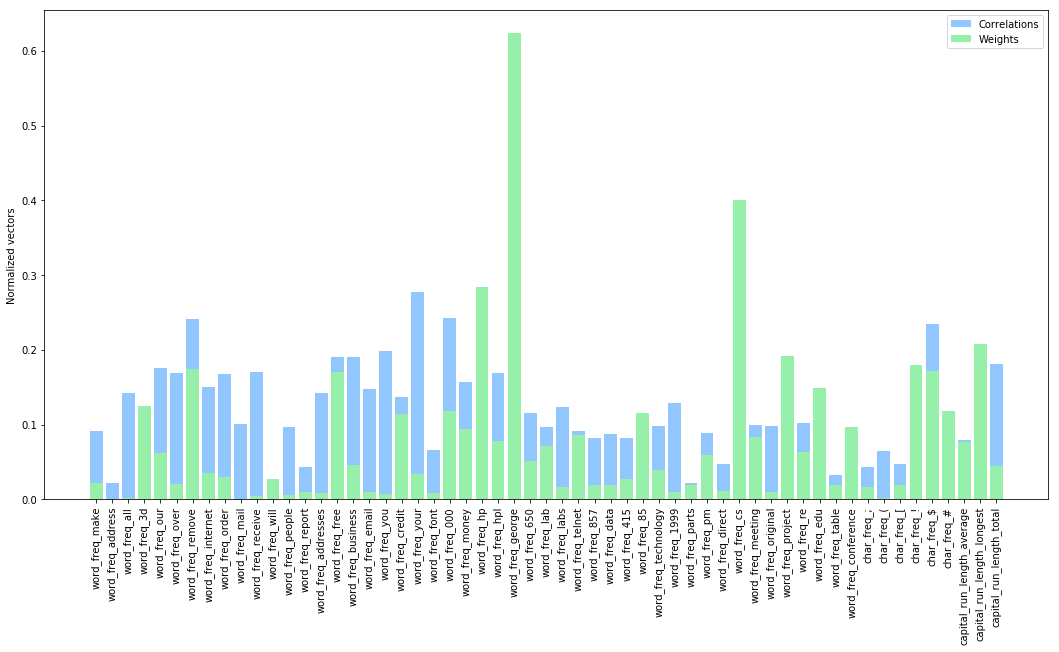

In [10]:
w = linear_svm_cv.best_estimator_.coef_[0]

w = np.abs(w)

# get unit vector 
w /= np.linalg.norm(w)

plt.figure(figsize=(18,9))
plt.bar(range(len(f)), a);
plt.bar(range(len(f)), w);
plt.xticks(range(len(f)), f, rotation='vertical');
plt.ylabel('Normalized vectors')
plt.legend(['Correlations', 'Weights'])
plt.show()

Let's take the top five weights and train a model based on the top five features. I will be adding features gradually and measure the accuracy per feature added.

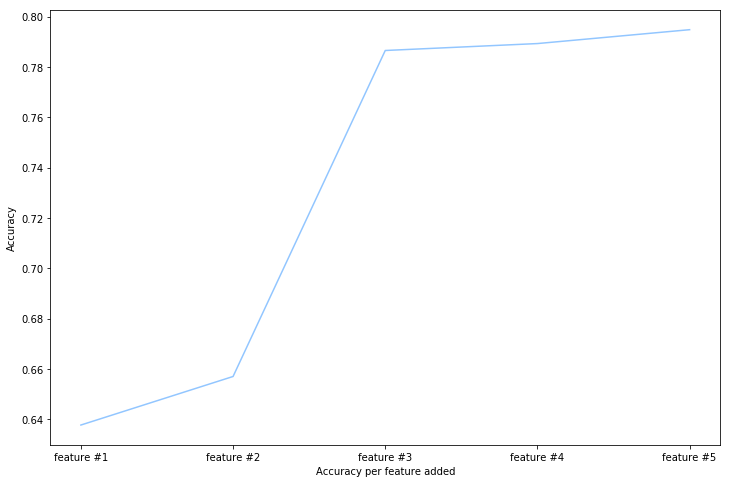

In [11]:
mod_svm_cv = LinearSVC(C = 2 , loss= "hinge", random_state=42)

# n most important features
n = 5

acc = []

for i in range(1,n+1):
    r = np.argsort(w)[::-1][:i] # gets the indicies of the first important i features
    X_train_w, X_test_w = X_train[:,r], X_test[:,r]
    mod_svm_cv.fit(X_train_w, y_train)
    y_pred = mod_svm_cv.predict(X_test_w)
    acc_score = metrics.accuracy_score(y_pred = y_pred, y_true = y_test)
    acc.append(acc_score)
    
plt.figure(figsize=(12,8))
plt.plot(range(n), acc);
plt.xticks(range(n), ['feature #{}'.format(x) for x in range(1,n+1)]);
plt.ylabel('Accuracy')
plt.xlabel('Accuracy per feature added')
plt.show()

With one feature the accuracy is low and spikes with the third feature added, then it grows slowly.

## 5. KERNELIZING SVM WITH THE GAUSSIAN RBF (30 pts)

Here I will use RBF kernel and tune its hyperparameters.

$
    \mathbf{K}_{\mathbb{RBF}}(\mathbf{x}^{(i)},\mathbf{x}^{(j)}) = \exp\left( -\gamma ||\mathbf{x}^{(i)} -\mathbf{x}^{(j)}||^2 \right)
$

In [12]:
from sklearn.svm import SVC

params = {'C': [1, 2, 5, 7, 10, 100, 150, 200, 500], 'gamma': [0.001, 0.005, 0.01, 0.05, 0.1]}

svm_rbf = GridSearchCV(SVC(kernel = 'rbf'), params, scoring = 'precision')

svm_rbf.fit(X_train, y_train)

y_score_rbf = svm_rbf.decision_function(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

rbf_fpr, rbf_tpr, _ = metrics.roc_curve(y_test, y_score_rbf)


rbf_acc = metrics.accuracy_score(y_pred = y_pred_rbf, y_true = y_test)
rbf_prec = metrics.precision_score(y_pred = y_pred_rbf, y_true = y_test)
rbf_recall = metrics.recall_score(y_pred = y_pred_rbf, y_true = y_test)
rbf_f1 = metrics.f1_score(y_true = y_test, y_pred = y_pred_rbf)
rbf_auc = metrics.roc_auc_score(y_true = y_test, y_score = y_pred_rbf)

print('Using the best parameters for Gaussian RBF', svm_rbf.best_params_)
print('Accuracy {:2.2%}'.format(rbf_acc))
print('Precision score {:2.2%}'.format(rbf_prec))
print('Recall score {:2.2%}'.format(rbf_recall))
print('F1 score {:2.2%}'.format(rbf_f1))

Using the best parameters for Gaussian RBF {'C': 2, 'gamma': 0.01}
Accuracy 94.21%
Precision score 96.16%
Recall score 92.61%
F1 score 94.35%


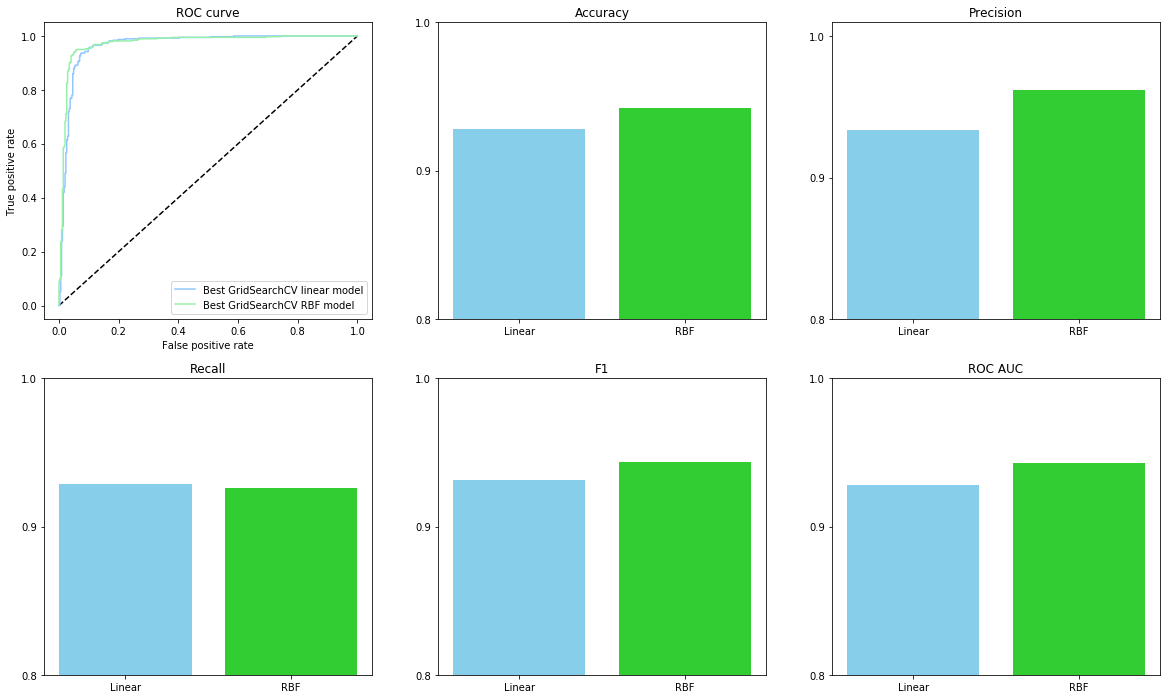

In [13]:
plt.figure(figsize=(20,12))

plt.subplot(231)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(cv_fpr, cv_tpr, label = 'Best GridSearchCV linear model')
plt.plot(rbf_fpr, rbf_tpr, label = 'Best GridSearchCV RBF model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')


plt.subplot(232)
plt.title('Accuracy')
plt.bar(range(2), [lin_acc, rbf_acc], color= ['skyblue', 'limegreen'])
plt.xticks(range(2), ['Linear', 'RBF'])
plt.yticks([x/10 for x in range(11)])
plt.ylim(0.8)

plt.subplot(233)
plt.title('Precision')
plt.bar(range(2), [lin_prec, rbf_prec], color= ['skyblue', 'limegreen'])
plt.xticks(range(2), ['Linear', 'RBF'])
plt.yticks([x/10 for x in range(11)])
plt.ylim(0.8)

plt.subplot(234)
plt.title('Recall')
plt.bar(range(2), [lin_recall, rbf_recall], color= ['skyblue', 'limegreen'])
plt.xticks(range(2), ['Linear', 'RBF'])
plt.yticks([x/10 for x in range(11)])
plt.ylim(0.8)

plt.subplot(235)
plt.title('F1')
plt.bar(range(2), [lin_f1, rbf_f1], color= ['skyblue', 'limegreen'])
plt.xticks(range(2), ['Linear', 'RBF'])
plt.yticks([x/10 for x in range(11)])
plt.ylim(0.8)

plt.subplot(236)
plt.title('ROC AUC')
plt.bar(range(2), [lin_auc, rbf_auc], color= ['skyblue', 'limegreen'])
plt.xticks(range(2), ['Linear', 'RBF'])
plt.yticks([x/10 for x in range(11)])
plt.ylim(0.8)

plt.show()

We notice that the RBF model consistently beats the linear model when measured against all the given metrics. I would use the RBF to generalize the model to datasets in real world applications. But will not implement this specific model without using more data since it seems to be biased towards certain features that might not scale well for larger datasets. Here is why:

In [14]:
print('Features of which weights have the heighest values with linear SVM: ', [f[x] for x in r])
print('Features of which weights have the heighest values with correlation: ', [f[x] for x in b])

Features of which weights have the heighest values with linear SVM:  ['word_freq_george', 'word_freq_cs', 'word_freq_hp', 'capital_run_length_longest', 'word_freq_project']
Features of which weights have the heighest values with correlation:  ['word_freq_your', 'word_freq_000', 'word_freq_remove', 'char_freq_$', 'word_freq_you']


The words George and CS seem arbitrary for large SVM weights, this might be due to the fact that they never occur in spam emails so it helps in the filtration or classification process. This might produce different values if we had a different dataset because words like George are less likely to be important.